In [2]:
import pandas as pd
import numpy as np
import joblib as jb
import tifffile
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio
from sklearn.metrics import r2_score
import cv2
from scipy import stats

In [4]:
df_data = jb.load('../data/generated_baseline_convolution/bands_cspm/val_data_bands_cspm_baseline.pkl.z')
df_data.head(3)

,b1,b2,b3,b4,b5,b6,b7,b8,cspmb7,z,x,y,rf_pred,lgbm_pred
0,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,23.382784,3.195862,233,1130,3.327069,3.263602
3,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,23.158824,3.268182,233,1133,3.207836,2.887565
5,0.1196,0.0866,0.0687,0.0451,0.0489,0.0323,0.0285,0.0229,23.607309,3.294375,233,1135,3.212436,3.188754


In [5]:
df_data.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,cspmb7,z,x,y,rf_pred,lgbm_pred
count,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000
mean,0.122902,0.093355,0.072601,0.047239,0.040707,0.026696,0.025109,0.020372,20.032202,7.165045,1148.165025,644.689995,7.293312,7.253924
std,0.003260,0.004409,0.005438,0.006995,0.007590,0.004354,0.004638,0.003903,5.301233,4.505792,467.484030,408.237719,3.812242,3.608358
min,0.115700,0.081300,0.054800,0.030900,0.026800,0.018900,0.014400,0.013600,9.348026,1.167273,233.000000,1.000000,1.565492,1.022126
25%,0.120400,0.090200,0.068700,0.042100,0.035100,0.023900,0.022100,0.017900,16.717153,3.479353,788.500000,323.000000,4.361494,4.643458
50%,0.123000,0.093600,0.073000,0.046300,0.039200,0.025800,0.024000,0.019600,18.696860,6.151290,1032.000000,604.000000,6.435930,6.394318
75%,0.125300,0.096400,0.076200,0.051300,0.044700,0.028200,0.026800,0.021800,21.717054,9.763485,1534.500000,931.500000,9.160880,8.851207
max,0.135300,0.113700,0.095200,0.080800,0.075300,0.054900,0.061200,0.057000,66.595318,25.765000,2295.000000,1637.000000,21.996673,21.900312


In [6]:
height = df_data.y.max() - df_data.y.min()
height

1636

In [7]:
width = df_data.x.max() - df_data.x.min()
width

2062

In [8]:
image = np.zeros((df_data.y.max()+1,df_data.x.max()+1))

In [9]:
image.shape

(1638, 2296)

In [10]:
for i, row in enumerate(df_data.itertuples()):
    x = row[-4]
    y = row[-3]
    rf_pred = row[-2]
    image[y][x] = rf_pred

In [11]:
image.max()

21.996673262912974

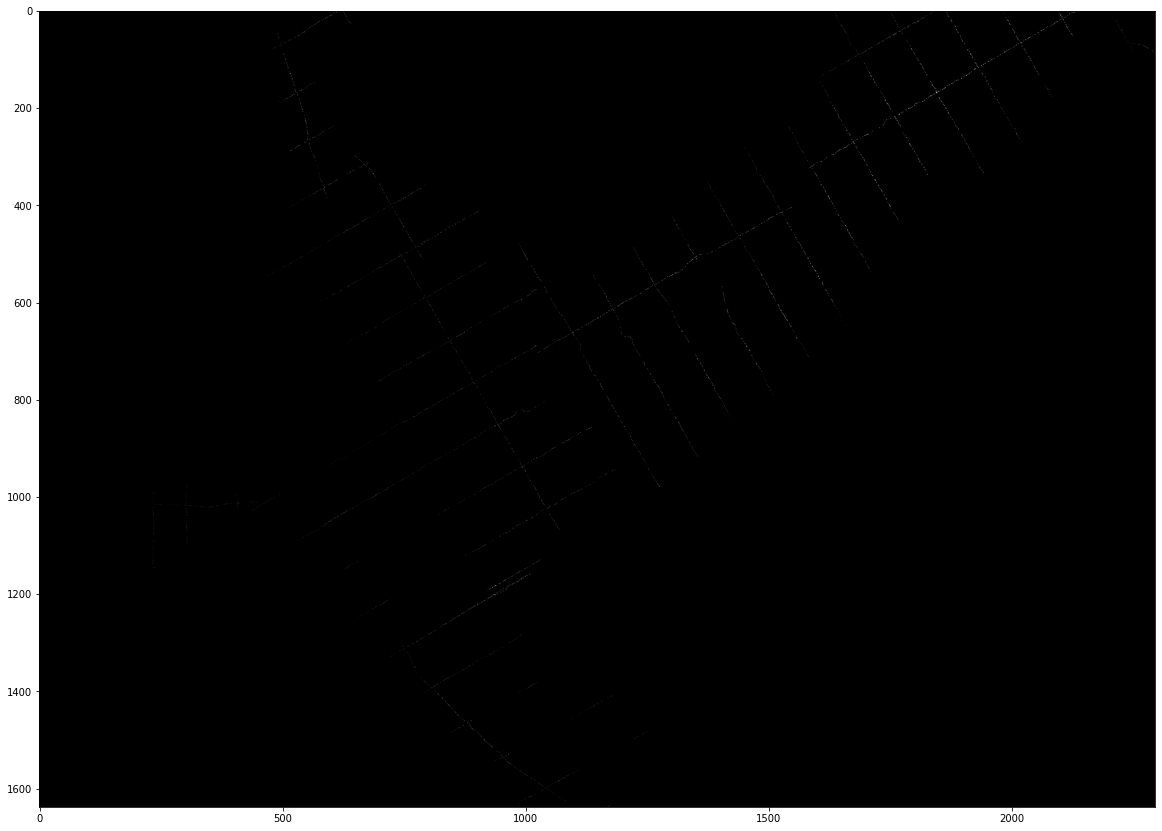

In [12]:
plt.figure(figsize=(20,15))
plt.imshow(image*100,'gray')

In [13]:
def convolution(image,kernel):
    result = image.copy()
    for y in range(int(kernel.shape[0]/2),image.shape[0]-int(kernel.shape[0]/2)):
        for x in range(int(kernel.shape[1]/2),image.shape[1]-int(kernel.shape[1]/2)):
            if(image[y][x] != 0):
                s = 0
                c = 0
                for i in range(kernel.shape[0]):
                    for j in range(kernel.shape[1]):
                        v = image[y+i-int(kernel.shape[0]/2)][x+j-int(kernel.shape[1]/2)] * kernel[i][j]
                        if(v != 0):
                            s += v
                            c += kernel[i][j]
                if(c!=0):
                    result[y][x] = s/float(c)
    return result

In [14]:
#r2 = 0.57
#kernel = np.array([[0.25,0.5,1,0.5,0.25],
#                   [0.5,1,1.5,1,0.5],
#                   [1,1.5,1.5,1.5,1],
#                   [0.5,1,1.5,1,0.5],
#                   [0.25,0.5,1,0.5,0.25]])

#r2 = 0.77
#kernel = np.array([[0.5,0.75,1,0.75,0.5],
#                   [0.75,1,1,1,0.75],
#                   [1,1,1,1,1],
#                   [0.75,1,1,1,0.75],
#                   [0.5,0.75,1,0.75,0.5]])

#r2 = 0.82
#kernel = np.array([[1,1,1,1,1],
#                   [1,1,1,1,1],
#                   [1,1,1,1,1],
#                   [1,1,1,1,1],
#                   [1,1,1,1,1]])


#r2 = 0.817
#kernel = np.ones((4,4))


#r2 = 0.826
#kernel = np.ones((6,6))

#r2 = 0.833
#kernel = np.ones((8,8))

#r2 = 0.836
#kernel = np.ones((10,10))

kernel = np.ones((15,15))

#r2 = 0.838
#kernel = np.ones((20,20))



#r2 = 0.832
#kernel = np.ones((25,25))

#r2 = 0.825
#kernel = np.ones((30,30))

#r2 = 0.809
#kernel = np.ones((40,40))



image_copy = convolution(image,kernel)

In [15]:
kernel

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.

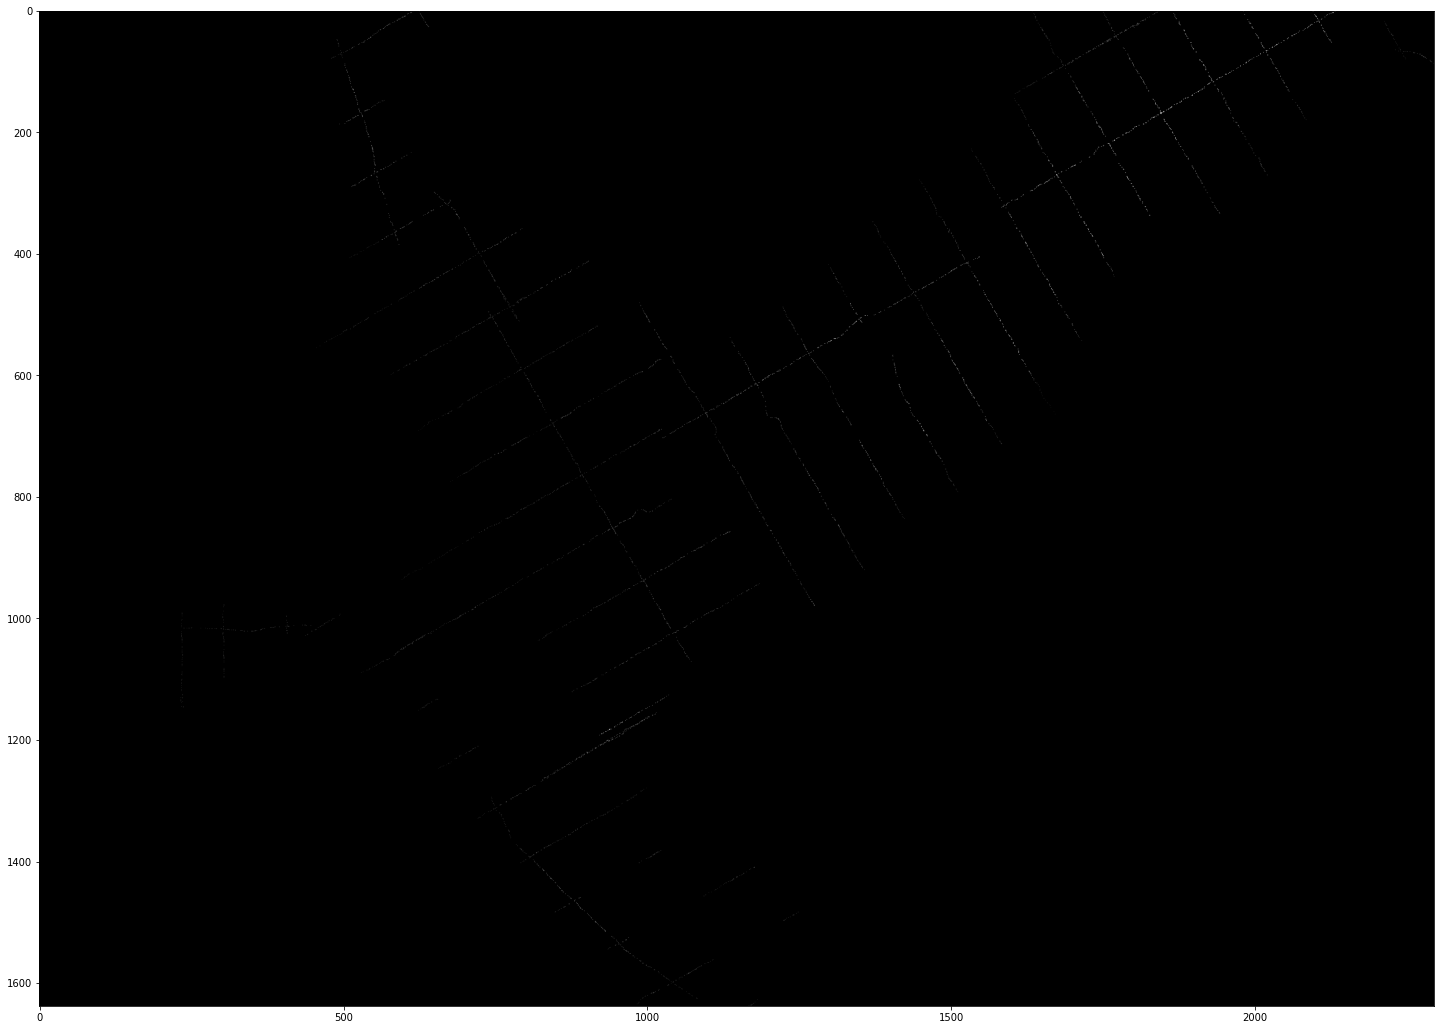

In [16]:
plt.figure(figsize=(25,20))
plt.imshow(image_copy*100,'gray')

In [17]:
new_df = pd.DataFrame(index=df_data.index)
new_df

""
0
3
5
6
8
...
19276
19277
19278
19280


In [20]:
df_data_copy = df_data.copy()
new_col = list()
for i, row in enumerate(df_data.itertuples()):
    x = row[-4]
    y = row[-3]
    new_col.append(image_copy[y][x])
df_data_copy['rf_pred_smooth'] = new_col

In [21]:
df_data_copy

,b1,b2,b3,b4,b5,b6,b7,b8,cspmb7,z,x,y,rf_pred,lgbm_pred,rf_pred_smooth
0,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,23.382784,3.195862,233,1130,3.327069,3.263602,3.252858
3,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,23.158824,3.268182,233,1133,3.207836,2.887565,3.260071
5,0.1196,0.0866,0.0687,0.0451,0.0489,0.0323,0.0285,0.0229,23.607309,3.294375,233,1135,3.212436,3.188754,3.242697
6,0.1196,0.0868,0.0674,0.0451,0.0485,0.0317,0.0296,0.0232,24.852202,3.353030,233,1136,3.168455,3.116440,3.242697
8,0.1224,0.0917,0.0725,0.0509,0.0554,0.0345,0.0331,0.0264,28.922021,2.230000,234,1003,2.726091,3.291766,2.998549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19276,0.1256,0.1026,0.0803,0.0529,0.0436,0.0275,0.0256,0.0217,20.408150,3.026562,2290,83,3.968316,3.429625,3.968316
19277,0.1277,0.1031,0.0824,0.0541,0.0464,0.0281,0.0267,0.0219,21.607165,2.920000,2290,84,5.098087,3.070840,5.098087
19278,0.1277,0.1018,0.0811,0.0550,0.0464,0.0281,0.0267,0.0222,21.607165,2.820312,2291,84,4.842504,6.546937,4.842504
19280,0.1267,0.1026,0.0805,0.0558,0.0473,0.0290,0.0263,0.0239,21.169079,2.594444,2292,85,4.370553,7.049632,4.370553


In [22]:
r2_score(df_data_copy['z'],df_data_copy['rf_pred_smooth'])

0.8402257382875102

In [23]:

r2_score(df_data_copy['z'],df_data_copy['rf_pred'])

0.7954639875979043

In [25]:
jb.dump(df_data_copy,'../data/generated_baseline_convolution/bands_cspm/val_data_bands_cspm_baseline_convolution.pkl.z')

['../data/generated_baseline_convolution/bands_cspm/val_data_bands_cspm_baseline_convolution.pkl.z']